# CNN Model to classify input text
## Part - 1: Training

In [3]:
# Import dependencies/libraries
import os
import re
import time

from cleantext import clean

import numpy as np
from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping
from keras.layers import (
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    GlobalMaxPooling1D,
    MaxPooling1D,
    TextVectorization,
)
from keras.optimizers import RMSprop

In [4]:
DATA_DIR = "../datasets/large-movie-dataset"
VOCAB_FILEPATH = "../datasets/large-movie-dataset/imdb.vocab"

# Define hyper-parameters
epochs = 64
batch_size = 128
embedding_dim = 128
hidden_dim = 64
max_sequence_length = 500
kernel_size = 5
max_features = 2048

In [5]:
# Load data and tokenize text
# Test data to test if the model architecture is working
# texts = np.array([
#     "Alice won the hackathon last month",
#     "We had a lovely breakfast",
#     "Maria died in a car accident",
#     "We got to see the sunrise yesterday",
#     "Mr. Rupert got hurt by a snake bite"
# ])
# #labels = ["happy", "happy", "sad", "happy", "sad"]
# labels = np.array([0, 0, 1, 0, 1])

rgx_html = re.compile(r"<[^>]+>")

# Load the dataset
dataset = {
    "test": {"reviews": [], "ratings": []},
    "train": {"reviews": [], "ratings": []},
}

def clean_text(text):
    # Clean the text
    cleaned_text = clean(text,
        lower=True,                     # lowercase text
        fix_unicode=True,               # fix various unicode errors
        to_ascii=True,                  # transliterate to closest ASCII representation
        # no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
        # no_urls=False,                  # replace all URLs with a special token
        # no_emails=False,                # replace all email addresses with a special token
        # no_phone_numbers=False,         # replace all phone numbers with a special token
        # no_numbers=False,               # replace all numbers with a special token
        # no_digits=False,                # replace all digits with a special token
        # no_currency_symbols=False,      # replace all currency symbols with a special token
        # no_punct=False,                 # remove punctuations
        replace_with_punct="",          # instead of removing punctuations you may replace them
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="<NUMBER>",
        replace_with_currency_symbol="<CUR>",
        lang="en"
    )

    cleaned_text = rgx_html.sub("", cleaned_text)
    return cleaned_text


# Loads IMDd Movie reviews dataset
def load_dataset():
    LABELS = ["neg", "pos"]

    for type in dataset.keys():
        print(f"Loading '{type}' data ...")
        LABEL_DIR = f"{DATA_DIR}/{type}"

        for label in os.listdir(LABEL_DIR):
            REVIEW_DIR = f"{LABEL_DIR}/{label}"
            score = LABELS.index(label) if label in LABELS else -1
            
            for filename in tqdm(
                os.listdir(REVIEW_DIR),
                desc=f"> '{label}' reviews"
            ):
                FILEPATH = f"{REVIEW_DIR}/{filename}"
                id, rating = map(int, filename.split(".")[0].split("_"))
                content = open(FILEPATH).read()

                # Clean the text
                cleaned_text = clean_text(content)

                # Add to the dataset
                dataset[type]["reviews"].append(cleaned_text)
                dataset[type]["ratings"].append(score)

        print()


# Load the dataset
load_dataset()

Loading 'test' data ...


> 'neg' reviews: 100%|██████████| 12500/12500 [00:05<00:00, 2164.48it/s]



Loading 'train' data ...


> 'neg' reviews: 100%|██████████| 12500/12500 [00:05<00:00, 2144.24it/s]

In [ ]:
# Prepare the training data
training_data = list(map(lambda l: np.array(l), dataset["train"].values()))
testing_data = list(map(lambda l: np.array(l), dataset["test"].values()))
texts, labels = training_data

# Print a few random examples
N = 5
indices = np.random.choice(range(0, len(testing_data[0])), size=N, replace=False)

print(f"{N} random training samples ->")
for index in indices:
    print(f"{'review' :<6} = {texts[index]}")
    print(f"{'rating' :<6} = {labels[index]}")
    print()

5 random training samples ->
review = the film is about a young man, michael, who cares for the elderly. one day he decides to kill some of the relatives of his clients. around the same time he decides to model his killing after the zodiac killer of the 60's. he gets in touch with the author of a book about the zodiac killer and they form a friendship. michael has a gun (aparently the only gun, as it seems to be in the hands of some of the other actors, only not portrayed as the same gun.) and he goes out a-killin'. original. this is a great film if you like b movies. i thought the idea of the movie was good, but the editing and the acting really drowned the plot. i thought the 'blood' was just too fake, the lighting was horrible in some places, and the dialog was just too standard. the movie was shot on video, which is okay, but the editing of the film just made for some weird 'plan 9' scenes. not a bad movie for fans of the b-movie genre, but if you want something with a bit more pol

In [ ]:
print("Generating lookup table ...", flush=True)
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=max_sequence_length,
    vocabulary=VOCAB_FILEPATH
)

# vectorize_layer.adapt(texts)

Generating lookup table ...


In [ ]:
def build_model(vectorize_layer):
    # Define the CNN model
    model = keras.Sequential([
        keras.Input(shape=(1,), dtype="string"),
        vectorize_layer,
        Embedding(max_features, embedding_dim),
        Dropout(0.5),
        Conv1D(
            max_features,
            kernel_size,
            padding="same",
            activation="relu",
            input_shape=(max_sequence_length, embedding_dim),
        ),
        MaxPooling1D(),
        Conv1D(
            max_features // 4,
            kernel_size,
            padding="same",
            activation="relu",
            input_shape=(max_sequence_length, embedding_dim),
        ),
        GlobalMaxPooling1D(),
        Flatten(),
        Dense(hidden_dim, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid", name="predictions"),
    ])

    optimizer = RMSprop(learning_rate=0.001)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

# Define and compile model
print("Building model ...", flush=True)
model = build_model(vectorize_layer)

# Print model summary
model.summary()

Building model ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 128)          262144    
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 500, 2048)         1312768   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 250, 2048)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2

In [ ]:
# Define early stopping callback
early_stopping_callback = EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
# Train model
print("Training model ...", flush=True)
history = model.fit(
    *training_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=testing_data,
    callbacks=[early_stopping_callback]
)

Training model ...
Epoch 1/64


2023-05-03 11:26:26.821369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-05-03 11:26:29.115804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


196/196 [==============================] - 45s 201ms/step - loss: 0.5565 - accuracy: 0.6930 - val_loss: 0.4098 - val_accuracy: 0.8142
Epoch 2/64
196/196 [==============================] - 39s 200ms/step - loss: 0.3952 - accuracy: 0.8351 - val_loss: 0.3436 - val_accuracy: 0.8473
Epoch 3/64
196/196 [==============================] - 39s 201ms/step - loss: 0.3544 - accuracy: 0.8557 - val_loss: 0.3669 - val_accuracy: 0.8458
Epoch 4/64
196/196 [==============================] - 40s 202ms/step - loss: 0.3238 - accuracy: 0.8678 - val_loss: 0.3199 - val_accuracy: 0.8622
Epoch 5/64
196/196 [==============================] - 40s 202ms/step - loss: 0.3031 - accuracy: 0.8793 - val_loss: 0.3402 - val_accuracy: 0.8564
Epoch 6/64
196/196 [==============================] - 40s 203ms/step - loss: 0.2832 - accuracy: 0.8870 - val_loss: 0.3006 - val_accuracy: 0.8738
Epoch 7/64
196/196 [==============================] - 40s 204ms/step - loss: 0.2644 - accuracy: 0.8952 - val_loss: 0.3106 - val_accuracy: 0.8

In [ ]:
# Evaluate model
print("Evaluating model score on test data ...", flush=True)
score = model.evaluate(*testing_data)
print(f"Model score: {score}")

Evaluating model score on test data ...
782/782 [==============================] - 14s 18ms/step - loss: 0.3006 - accuracy: 0.8738
Model score: [0.30055373907089233, 0.8737999796867371]


In [ ]:
# Make predictions
# Select few random examples from testing data
N = 50
indices = np.random.choice(range(0, len(testing_data[0])), size=N, replace=False)
texts = np.array([ testing_data[0][index] for index in indices ])
labels = np.array([ testing_data[1][index] for index in indices ])

print(f"Making {N} predictions ...", flush=True)
predictions = model.predict(texts)
print()

for review, rating, prediction in zip(texts, labels, predictions):
    print(f"{'review' :<10} = {review}")
    print(f"{'rating' :<10} = {rating}")
    prediction = round(prediction[0])
    print(f"{'prediction' :<10} = {prediction}")
    print()

Making 50 predictions ...
2/2 [==============================] - 0s 110ms/step

review     = this movie gives us some wwii history along with some touching romance, a little fantasy and meaningful emotion - and beautiful scenery. nicholas cage never fails us, and here again does a great job. and so do the other principle characters. one key charater, the physician/father played by john hurd, delivers (to his daughter) one of the best definitions of love i've ever heard. some of the events are a bit too coincidental to be real, but i excused that, knowing that this is partly fairy tale and fantacy. my wife and i really liked the film. and it is nice to watch people taking the risks to love the enemy. one man who left the theatre near us said to his wife, "now that's the way to wage war!" i think you'll see what he means when you watch the italian occupiers of this lovely greek island.
rating     = 1
prediction = 1

review     = so often these "lifetime" flicks are one-dimension, with ov

In [ ]:
# Save the model (for later use)
timestamp = int(time.time())
MODEL_FILEPATH = f"../models/models-{timestamp}.h5"

print(f"Saving trained model to '{MODEL_FILEPATH}' ...")
model.save(MODEL_FILEPATH)

Saving trained model to '../models/models-1683093761.h5' ...


## Part - 2: Testing

In [ ]:
# Import dependencies/libraries
from cleantext import clean
import numpy as np
import keras

In [5]:
# Specify which model to use
MODEL_FILEPATH = f"../models/models-1683093761.h5"

# Load the model
model = keras.models.load_model(MODEL_FILEPATH)

# Sample review from IMDb
text = "Avatar is a beautiful piece of film and a true event. It does exactly what cinema was always intended to - it takes us away from our problems and worries for a few hours and gives us memorable images which will undoubtedly and deservedly enter into the cultural lexicon to stay for the foreseeable future."
cleaned_text = clean(text)

print(f"{'Text' :<12}: {text}")
print(f"{'Cleaned text' :<12}: {cleaned_text}")

prediction = model.predict(np.array([cleaned_text]), verbose=0)[0][0]
print(f"{'Prediction': <12}: {prediction:.4f}")

Text        : Avatar is a beautiful piece of film and a true event. It does exactly what cinema was always intended to - it takes us away from our problems and worries for a few hours and gives us memorable images which will undoubtedly and deservedly enter into the cultural lexicon to stay for the foreseeable future.
Cleaned text: avatar is a beautiful piece of film and a true event. it does exactly what cinema was always intended to - it takes us away from our problems and worries for a few hours and gives us memorable images which will undoubtedly and deservedly enter into the cultural lexicon to stay for the foreseeable future.
Prediction  : 0.9990


: 

# DBSCAN
## Clustering processed data into group of clusters

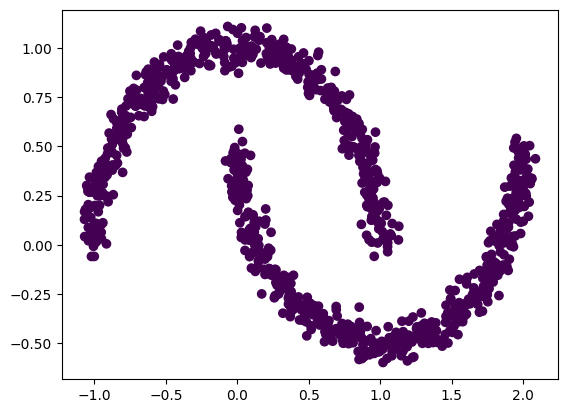

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

# Generate sample data
X, y = make_moons(n_samples=1000, noise=0.05)

# Define and fit the DBSCAN clustering algorithm
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan.fit(X)

# Plot the clusters
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels_)
plt.show()